# QRBS and Invasive Ductal Carcinoma

We are going to implement a **RBS** for a **Invasive Ductal Carcinoma** (**IDC**) using the **QRBS**. The rules for this kind of system can be shown in the following diagram where the different input symptoms are presented.

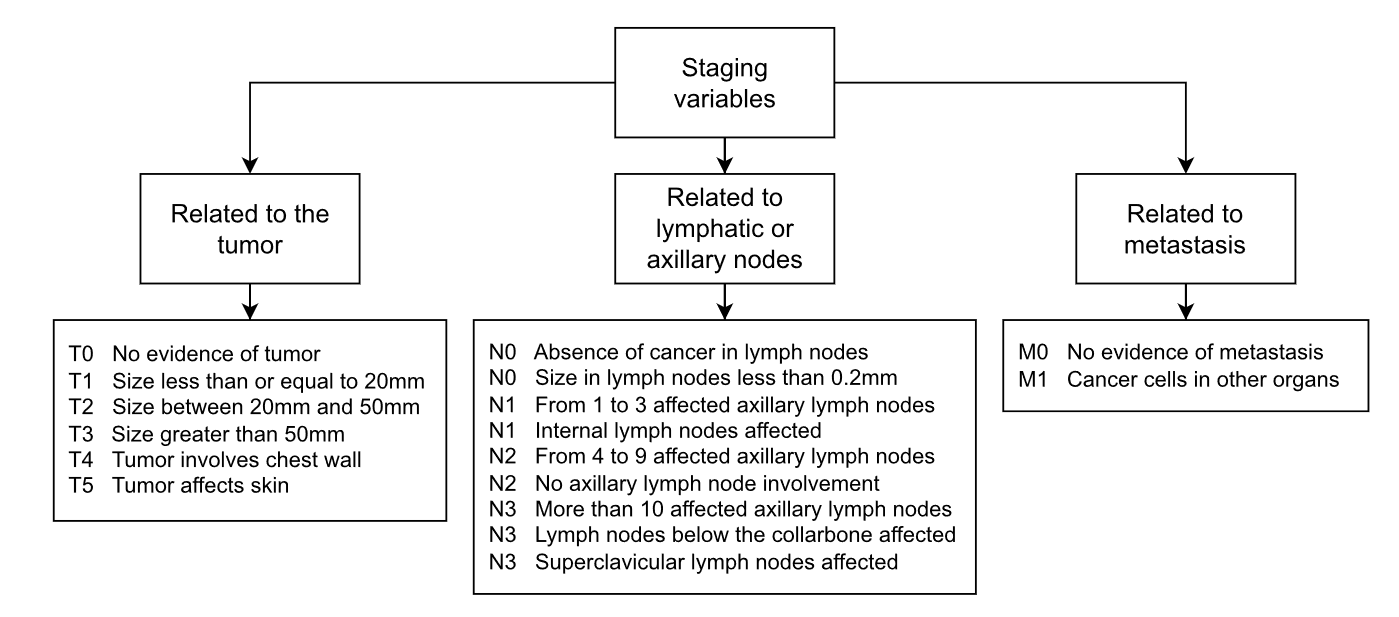

Depending on the combination of symptoms a compatible TMN classification can arise. Based on this TMN classification the following **IDC** stages can be identified.


| IDC-Stage | Compatible TNM classification                        |
|-----------|------------------------------------------------------|
| I-A       | T1 N0 M0                                             |
| I-B       | T0 N1 M0 / T1 N1 M0                                  |
| II-A      | T0 N1 M0 / T1 N1 M0 / T2 N0 M0                       |
| II-B      | T2 N1 M0 / T3 N0 M0                                  |
| III-A     | T0 N2 M0 / T1 N2 M0 / T2 N0 M0 / T3 N2 M0 / T3 N1 M0 |
| III-B     | T4 N0 M0 / T4 N1 M0 / T4 N2 M0                       |
| III-C     | TX N3 M0                                             |
| IV        | TX NY M1                                             |



**BE AWARE**

For this version of the **IDC** the number of qubits used by the **QRBS** is high (up to 28 qubits circuits can be generated) so for executing the simulation **HPC** resources are mandatory. In fact, for simulating the circuits, the Eviden **Quantum Learning Machine (QLM)** and the **LinAlg** solver should be used. 

If the user does not have access to a **QLM** this notebook can not be executed!! 

In [ ]:
import sys
sys.path.append("../../")
sys.path.append("../")
import itertools as it
import pandas as pd

In [ ]:
from neasqc_qrbs.qrbs import QRBS
from neasqc_qrbs.knowledge_rep import AndOperator, OrOperator, NotOperator

In [ ]:
# myQLM qpus
from qpu.select_qpu import select_qpu
# List with the strings that should be provided for an ideal QPU
ideal_qpus = ["c", "python", "linalg", "mps", "qlmass_linalg", "qlmass_mps"]
qpu_config_c = {
    "qpu_type": ideal_qpus[4], 
}
qpu = select_qpu(qpu_config_c)

In [ ]:
from selectable_qpu import SelectableQPU
qpu_selected = SelectableQPU()

## 1. IDC using QRBS


The following function, **idc_qrbs**, implements the IDC using the **QRBS** software.

In [ ]:
def idc_qrbs(row, qpu, type_qpu=None, shots=None, model='cf'):    
    idc =  QRBS()
    # Setting the input facts
    
    # Related to tumor
    t0 = idc.assert_fact('T0', 'No evidence of tumor')
    t1 = idc.assert_fact('T1', 'Size less than or equal to 20mm')
    t2 = idc.assert_fact('T2', 'Size between 20mm and 50mm')
    t3 = idc.assert_fact('T3', 'Size greater than 50mm')
    t4 = idc.assert_fact('T4', 'Tumor involves chest wall')
    t5 = idc.assert_fact('T5', 'Tumor affects skin')
    
    # Related to lymphatic or auxilary nodes
    n0a = idc.assert_fact('N0A', 'Absence of cancer in lymph nodes')
    n0b = idc.assert_fact('N0B', 'Size in lymph nodes less than 0.2mm')
    n0 = OrOperator(n0a, n0b)
    
    n1a = idc.assert_fact('N1A', 'From 1 to 3 affected axillary lymph nodes')
    n1b = idc.assert_fact('N1B', 'Internal lymph nodes affected')
    n1 = OrOperator(n1a, n1b)
    
    n2a = idc.assert_fact('N2A', 'From 4 to 9 affected axillary lymph nodes')
    n2b = idc.assert_fact('N2B', 'No axillary lymph node involvement')
    n2 = OrOperator(n2a, n2b)
    
    n3a = idc.assert_fact('N3A', 'More than 10 affected axillary lymph nodes')
    n3b = idc.assert_fact('N3B', 'Lymph nodes below the collarbone affected')
    n3c = idc.assert_fact('N3C', 'Superclavicular lymph nodes affected')

    n3 = OrOperator(n3a, OrOperator(n3b, n3c))   
    
    # Related to metastasis
    m0 = idc.assert_fact('M0', 'No evidence of metastasis')
    m1 = idc.assert_fact('M1', 'Cancer cells in other organs')
    
    inputs = [t0, t1, t2, t3, t4, t5, n0a, n0b, n1a, n1b, n2a, n2b, n3a, n3b, n3c, m0, m1]
    
    # Fixed the precision of eac input fact
    for i in inputs:
        i.precision = row[i.attribute]

    # Combination of input facts for creating TNM staging system
    t1n0m0 = AndOperator(t1, AndOperator(n0, m0))    
    t0n1m0 = AndOperator(t0, AndOperator(n1, m0))
    t1n1m0 = AndOperator(t1, AndOperator(n1, m0))
    t2n0m0 = AndOperator(t2, AndOperator(n0, m0))
    t2n1m0 = AndOperator(t2, AndOperator(n1, m0))
    t3n0m0 = AndOperator(t3, AndOperator(n0, m0))
    t0n2m0 = AndOperator(t0, AndOperator(n2, m0))
    t1n2m0 = AndOperator(t1, AndOperator(n2, m0))
    t3n2m0 = AndOperator(t3, AndOperator(n2, m0))
    t3n1m0 = AndOperator(t3, AndOperator(n1, m0))
    t4n0m0 = AndOperator(t4, AndOperator(n0, m0))
    t4n1m0 = AndOperator(t4, AndOperator(n1, m0))
    t4n2m0 = AndOperator(t4, AndOperator(n2, m0))
    txn3m0 = AndOperator(n3, m0)
    txnym1 = m1
    
    # Output facts
    ia   = idc.assert_fact('IA', 'Stage I-A')
    ib   = idc.assert_fact('IB', 'Stage I-B')
    iia  = idc.assert_fact('IIA', 'Stage II-A')
    iib  = idc.assert_fact('IIB', 'Stage II-B')
    iiia = idc.assert_fact('IIIA', 'Stage III-A')
    iiib = idc.assert_fact('IIIB', 'Stage III-B')
    iiic = idc.assert_fact('IIIC', 'Stage III-C')
    iv   = idc.assert_fact('IV', 'Stage IV')
    
    outputs = [ia, ib, iia, iib, iiia, iiib, iiic, iv]
    
    # Rules of the IDC
    rule_ia    = idc.assert_rule(t1n0m0, ia, 1.0)
    rule_ib    = idc.assert_rule(OrOperator(t0n1m0, t1n1m0), ib, 1.0)
    rule_iia   = idc.assert_rule(OrOperator(t0n1m0, OrOperator(t1n1m0, t2n0m0)), iia, 1.0)
    rule_iib   = idc.assert_rule(OrOperator(t2n1m0, t3n0m0), iib, 1.0)
    rule_iiia  = idc.assert_rule(
        OrOperator(
            t0n2m0, 
            OrOperator(
                OrOperator(t1n2m0, t2n0m0), 
                OrOperator(t3n2m0, t3n1m0)
            )
        ),
        iiia, 
        1.0
    )
    rule_iiib  = idc.assert_rule(OrOperator(t4n0m0, OrOperator(t4n1m0, t4n2m0)), iiib, 1.0)
    rule_iiic  = idc.assert_rule(txn3m0, iiic, 1.0)
    rule_iv    = idc.assert_rule(txnym1, iv, 1.0) 
    
    # Defining the islands
    staging_ia    = idc.assert_island([rule_ia])
    staging_ib    = idc.assert_island([rule_ib])
    staging_iia   = idc.assert_island([rule_iia])
    staging_iib   = idc.assert_island([rule_iib])
    staging_iiia  = idc.assert_island([rule_iiia])
    staging_iiib  = idc.assert_island([rule_iiib])
    staging_iiic  = idc.assert_island([rule_iiic])
    staging_iv    = idc.assert_island([rule_iv])    
    
    qpu.execute(idc, qpu=type_qpu, shots=shots, model=model)
    
    
    data = [out.precision for out in outputs]
    columns = ["Stage I-A", "Stage I-B", "Stage II-A", "Stage II-B",
        "Stage III-A", "Stage III-B", "Stage III-C", "Stage IV"
    ]
    pdf = pd.DataFrame(data, index = columns).T
    return pdf

The input symptoms will be categorical variables.  The possible combination for *T* (related tumour), *N* (related lymphatic or auxiliary nodes) and *M* (linked to metastasis) symptoms will be created.

In [ ]:
#Posible t values
t = [[float(i==j) for i in range(6)] for j in range(5)]
#Posible n values
n = [[float(i==j) for i in range(9)] for j in range(9)]
m = [[int(i==j) for i in range(2)] for j in range(2)]
data = [list(it.chain.from_iterable(i)) for i in it.product(t, n, m)]
columns = ['T0','T1','T2','T3','T4','T5','N0A','N0B','N1A','N1B','N2A','N2B','N3A','N3B','N3C','M0','M1']
idc_df = pd.DataFrame(data, columns=columns)

In [ ]:
idc_df

## 2. Testing IDC

In the following cell, the code for testing each possible staging is developed.

### 2.1 Stage I-A

Only classification **T1/N0/M1** gives this stage

In [ ]:
# Selecting the inputs that provides a Stage I-A
stage_1_a = (idc_df["T1"] ==1) & ((idc_df["N0A"] ==1) |(idc_df["N0B"] ==1)) & (idc_df["M0"] ==1.0)

In [ ]:
step = idc_df[stage_1_a]

pdf_stage_1_a = pd.concat([idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])
pdf_stage_1_a.reset_index(drop=True, inplace=True)

In [ ]:
pdf_stage_1_a.index = ["T1/N0A/M0", "T1/N0B/M0"]

In [ ]:
pdf_stage_1_a

#### Results: Stage I-A: T1 N0 M0

The staging for **T1N0M0** should be **Stage IA**. The Figure presents the output precision for all the stages for all possible **T1N0M0** (*T1/N0A/M0* and *T1/N0B/M0*)

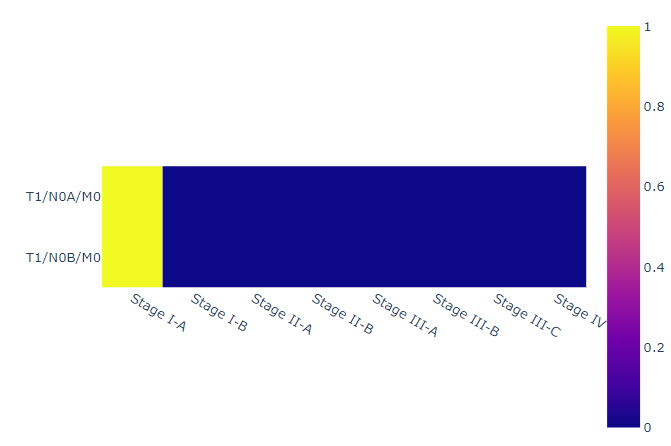

### 2.2 Stage I-B

Classification **T0N1M0** and **T1/N1/M0** provide the **Stage I-B** but they can give to classification **Stage II-A**

In [ ]:
# Stage I-B (II-A)
stage_1_b = (
    ((idc_df["T0"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T1"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0))
)

In [ ]:
step = idc_df[stage_1_b] 
print(step)

pdf_stage_1_b = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])
pdf_stage_1_b.reset_index(drop=True, inplace=True)

In [ ]:
pdf_stage_1_b.index = ["T0/N1A/M0", "T0/N1B/M0","T1/N1A/M0", "T1/N1B/M0"]

In [ ]:
pdf_stage_1_b

#### Results: Stage I-B: T0 N1 M0 / T1 N1 M0

The staging for **T0N1M0** and **T1/N1/M0** can be **Stage I-B** or **Stage II-A**. The Figure presents the output precision for all the stages for all possible **T0N1M0** and **T1/N1/M0** (*T0/N1A/M0*, *T0/N1B/M0*, *T1/N1A/M0*, *T1/N1B/M0*)

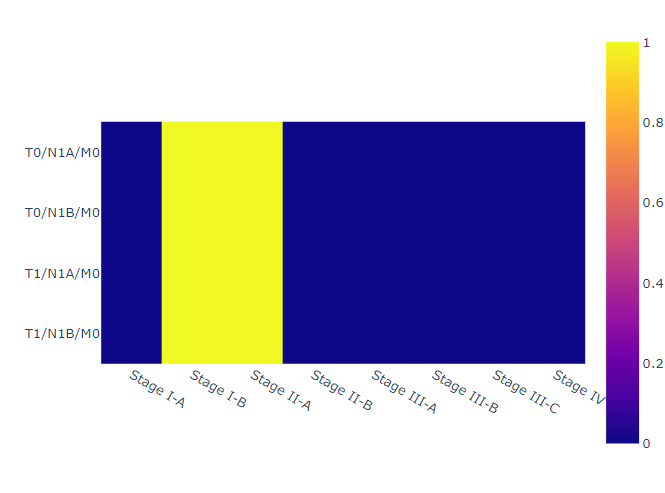

### 2.3 Stage II-A

Classifications **T0N1M0**, **T1N1M0** and **T2N0M0** can provide a **Stage IIA** but **T0N1M0**, **T1N1M0** can provide a **Stage I-B** and **T2N0M0** can provided a **Stage III-A** too.


In [ ]:
# Stage II-A (or I-B)
# Stage II-A (or III-A)

stage_2_a = (
    ((idc_df["T0"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T1"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T2"] ==1) & ((idc_df["N0A"] ==1) |(idc_df["N0B"] ==1)) & (idc_df["M0"] ==1.0)) 
)

In [ ]:
step = idc_df[stage_2_a]
print(step)
pdf_stage_2_a = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])


In [ ]:
pdf_stage_2_a.index= ["T0/N1A/M0", "T0/N1B/M0", "T1/N1A/M0", "T1/N1B/M0", "T2/N0A/M0", "T2/N0B/M0"]

In [ ]:
pdf_stage_2_a

#### Results: Stage II-A: T0 N1 M0 / T1 N1 M0 / T2 N0 M0

The staging for **T0N1M0**, **T1N1M0** can be **Stage I-B** or **Stage IIA** and for **T2N0M0** can be **Stage II-A** or **Stage III-A**.

The Figure presents the output precision for all the stages for all possible **T0N1M0**, **T1N1M0** (*T0/N1A/M0*, *T0/N1B/M0*, *T1/N1A/M0*, *T1/N1B/M0*) and for **T2N0M0** (*T2/N0A/M0*, *T2/N0B/M0*)


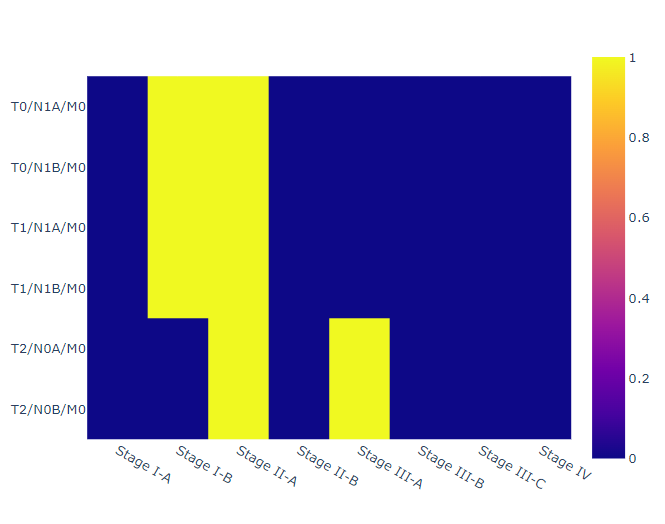

### 2.4 Stage II-B

Classifications **T2N1M0** and **T3N0M0** are **Stage II-B**


In [ ]:
# Stage II-B

stage_2_b = (
    ((idc_df["T2"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T3"] ==1) & ((idc_df["N0A"] ==1) |(idc_df["N0B"] ==1)) & (idc_df["M0"] ==1.0)) 
)

In [ ]:
step = idc_df[stage_2_b]
print(step)
pdf_stage_2_b = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])

In [ ]:
pdf_stage_2_b.index = ["T2/N1A/M0", "T2/N1B/M0", "T3/N0A/M0", "T3/N0B/M0"]

In [ ]:
pdf_stage_2_b

In [ ]:
pdf_stage_2_b.to_csv("pdf_stage_2_b.csv", sep=";")

In [ ]:
fig = px.imshow(pdf_stage_2_b, range_color=(0,1))
fig.show()

#### Results: Stage II-B: T2 N1 M0 / T3 N0 M0

The staging for **T2N1M0** and **T3N0M0** are **Stage II-B**. 

The Figure presents the output precision for all the stages for all possible **T2N1M0** and **T3N0M0** (*T2/N1A/M0*, *T2/N1B/M0*, *T3/N0A/M0*, *T3/N0B/M0*)


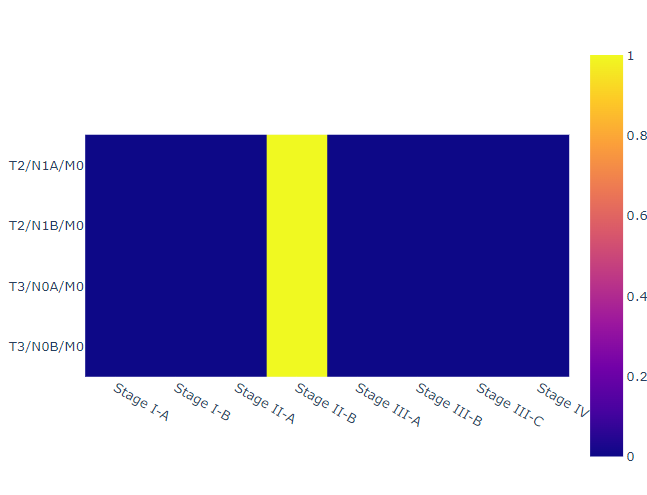

### 2.4 Stage III-A

Classification for **T0N2M0**, **T1N2M0**, **T3N1M0** and **T3N2M0** are **Stage III-A**. For **T2N0M0** the solution can be **Stage III-A** or **Stage II-A**


In [ ]:
# Stage III-A

stage_3_a = (
    ((idc_df["T0"] ==1) & ((idc_df["N2A"] ==1) |(idc_df["N2B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T1"] ==1) & ((idc_df["N2A"] ==1) |(idc_df["N2B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T2"] ==1) & ((idc_df["N0A"] ==1) |(idc_df["N0B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T3"] ==1) & ((idc_df["N2A"] ==1) |(idc_df["N2B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T3"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0))
)

In [ ]:
step = idc_df[stage_3_a]
print(step)
pdf_stage_3_a = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])

In [ ]:
indices = [
    "T0/N2A/M0", "T0/N2B/M0", "T1/N2A/M0", "T1/N2B/M0", 
    "T2/N0A/M0","T2/N0B/M0", "T3/N1A/M0","T3/N1B/M0",
    "T3/N2A/M0", "T3/N2B/M0"
]

pdf_stage_3_a.index = indices

In [ ]:
pdf_stage_3_a

#### Results: Stage III-A: T0 N2 M0 / T1 N2 M0 / T2 N0 M0 / T3 N2 M0 / T3 N1 M0

The staging for **T0N2M0**, **T1N2M0**, **T3N1M0** and **T3N2M0** is **Stage III-A** and for **T2N0M0** can be **Stage III-A** or **Stage II-A**.

The Figure presents the output precision for all the stages for all possible 
**T0N2M0**, **T1N2M0**, **T3N1M0** and **T3N2M0** (*T0/N2A/M0*, *T0/N2B/M0*, *T1/N2A/M0*, *T1/N2B/M0*, *T3/N1A/M0*, *T3/N1B/M0*, *T3/N2A/M0*, *T3/N2B/M0*) and for all possible **T2N0M0** (*T2/N0A/M0*,*T2/N0B/M0*)

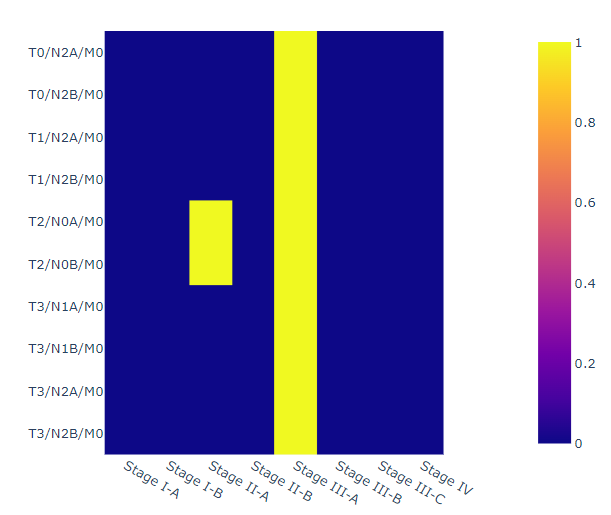

### 2.5 Stage III-B

Classification for **T4N0M0**, **T4N1M0** and **T4N2M0** is **Stage III-B**.


In [ ]:
# Stage III-B

stage_3_b = (
    ((idc_df["T4"] ==1) & ((idc_df["N0A"] ==1) |(idc_df["N0B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T4"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T4"] ==1) & ((idc_df["N2A"] ==1) |(idc_df["N2B"] ==1)) & (idc_df["M0"] ==1.0))
)

In [ ]:
step = idc_df[stage_3_b]
print(step)
pdf_stage_3_b = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])

In [ ]:
pdf_stage_3_b.index = ["T4/N0A/M0", "T4/N0B/M0", "T4/N1A/M0", "T4/N1B/M0", "T4/N2A/M0", "T4/N2B/M0"]

In [ ]:
pdf_stage_3_b

#### Results: Stage III-B: T4 N0 M0 / T4 N1 M0 / T4 N2 M0

The staging for **T4N0M0**, **T4N1M0** and **T4N2M0** is **Stage III-B**.


The Figure presents the output precision for all the stages for all possible **T4N0M0**, **T4N1M0** and **T4N2M0** (*T4/N0A/M0*, *T4/N0B/M0*, *T4/N1A/M0*, *T4/N1B/M0*, *T4/N2A/M0*, *T4/N2B/M0*)



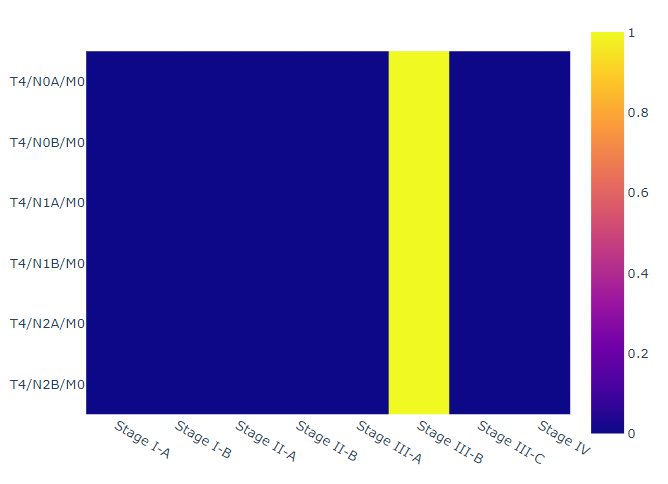

### 2.6 Stage III-C

Classification for **TXN3M0** is **Stage III-C**

In [ ]:
# Stage III-C
stage_3_c = (
    ((idc_df["N3A"] == 1) | (idc_df["N3B"] == 1) | (idc_df["N3C"] == 1)) &
    (idc_df["M0"] == 1)
)

In [ ]:
step = idc_df[stage_3_c]
print(step)
pdf_stage_3_c = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])

In [ ]:
pdf_stage_3_c.index = ["T"+str(i)+j+"M0" for i in range(0,5) for j in ["N3A", "N3B","N3C"]]

In [ ]:
pdf_stage_3_c

#### Results: Stage III-C: TX N3 M0

The staging for **TXN3M0**  is **Stage III-C**.

The Figure presents the output precision for all the stages for all possible **TXN3M0** (*T0N3AM0*, *T0N3BM0*, *T0N3CM0*, *T1N3AM0*, *T1N3BM0*, *T1N3CM0*, *T2N3AM0*, *T2N3BM0*, *T2N3CM0*, *T3N3AM0*, *T3N3BM0*, *T3N3CM0*, *T4N3AM0*, *T4N3BM0*, *T4N3CM0*)

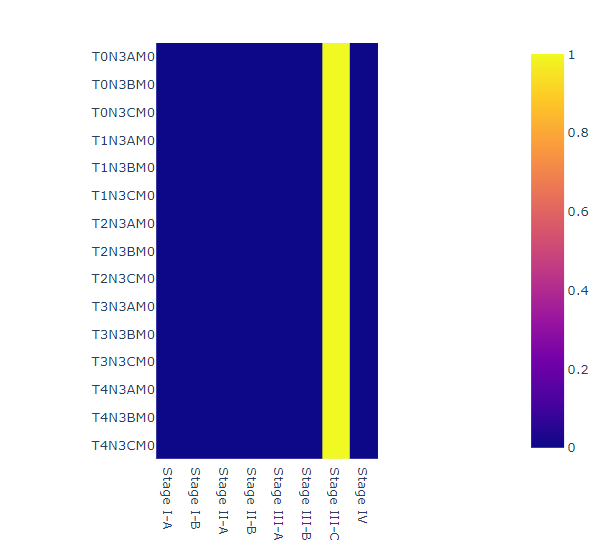

### 2.7 Stage IV

Classification for **TXNYM1** is **Stage IV**

In [ ]:
# Stage IV
stage_4 = (
    idc_df["M1"] == 1
)

In [ ]:
step = idc_df[stage_4]
print(step)
pdf_stage_4 = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])


In [ ]:
pdf_stage_4.index = [i+j+"M1"for i in ["T0", "T1", "T2", "T3", "T4"] for j in ["N0A", "N0B", "N1A", "N1B", "N2A", "N2B", "N3A", "N3B", "N3C"]]

In [ ]:
pdf_stage_4

In [ ]:
pdf_stage_4.to_csv("pdf_stage_4.csv", sep=";")

In [ ]:
fig = px.imshow(pdf_stage_4, range_color=(0,1))
fig.show()

#### Results: Stage IV: TX NY M1

The staging for **TXNYM1** is **Stage IV**

The Figure presents the output precision for all the stages for all possible **TXNYM1** 

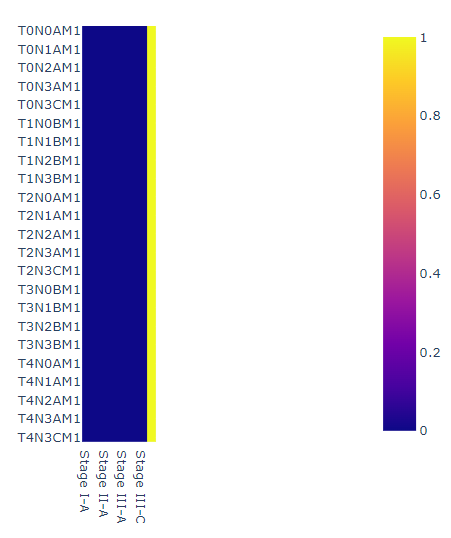

### 2.8 No Staging

Finally there some input symptoms that do not give place to a output stage.


In [ ]:
no_stage = (
    ~(stage_1_a | stage_1_b | stage_2_a | stage_2_b | stage_3_a | stage_3_b | stage_3_c | stage_4)
)

In [ ]:
step = idc_df[no_stage]
print(step)
pdf_no_stage = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])

In [ ]:
pdf_no_stage.index = ["T0/N0A/M0", "T0/N0B/M0", "T2/N2A/M0", "T2/N2B/M0"]

In [ ]:
pdf_no_stage

#### Results: No Stage

The Following inputs *T0/N0A/M0*, *T0/N0B/M0*, *T2/N2A/M0*, *T2/N2B/M0* do not give any stage.

The Figure presents the output precision for all the stages for *T0/N0A/M0*, *T0/N0B/M0*, *T2/N2A/M0*, *T2/N2B/M0*:

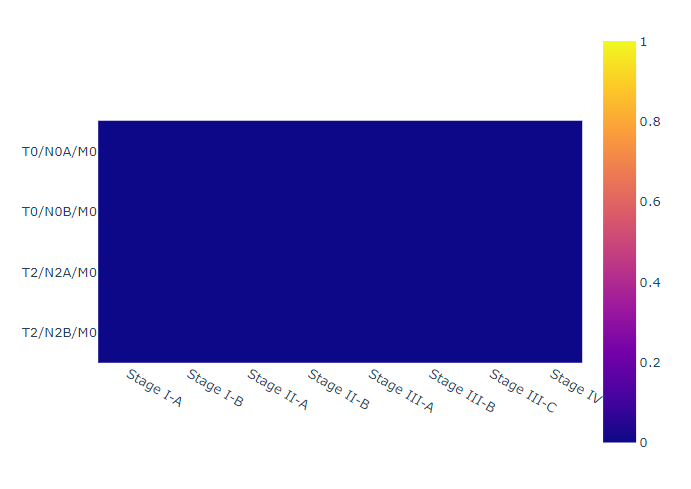

## 3. Imprecision in IDC

Until now the input symptoms were used as categorical variables, so the practician is 100\% sure about the value of the input. But this is not the real behaviour in real medicine. The doctor is not always sure about the symptoms and some probability can be assigned to them. 

The **QRBS** implementation of the IDC has the ability to propagate this imprecision in the inputs in a natural way and assign a final probability for the output staging (so stagings that will never appear when categorical inputs are used would have arisen if some imprecision is provided to the inputs).

In the following cells, some imprecision is assigned arbitrarily (and without any medical knowledge) to show how the outputs precision obtained by the **QRBS** IDC are modified.

In [ ]:
t = [
    [0.3, 0.7, 0, 0, 0, 0],
    [0.0, 0.8, 0.2, 0, 0, 0],    
    [0.0, 0.0, 0.6, 0.4, 0, 0],    
]


n = [
    [0, 0.8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0.8, 0, 0.2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0.7, 0, 0.3, 0, 0],    
]

m = [[1, 0]]

data = [list(it.chain.from_iterable(i)) for i in it.product(t, n, m)]

In [ ]:
data

In [ ]:
columns = ['T0','T1','T2','T3','T4','T5','N0A','N0B','N1A','N1B','N2A','N2B','N3A','N3B','N3C','M0','M1']
idc_df = pd.DataFrame(data, columns=columns)
labels = [
    "T0T1/N0/M0", "T0T1/N1N2/M0", "T0T1/N2N3/M0", 
    "T1T2/N0/M0", "T1T2/N1N2/M0", "T1T2/N2N3/M0",
    "T2T3/N0/M0", "T2T3/N1N2/M0", "T2T3/N2N3/M0",
]
idc_df["labels"] = labels

In [ ]:
stages = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=0) 
     for row in idc_df.iterrows()
    ]
)

In [ ]:
stages.index = labels

In [ ]:
stages

As can be seen in the Figure, stages that do not arise when input symptoms are categorical appear when some imprecision is allowed.  Additionally, the symptoms that before arose categorically, with output precision of 1.0, now have lower ones




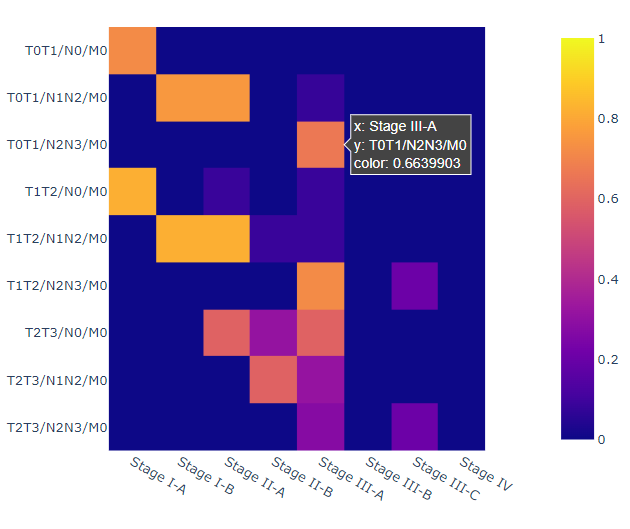